In [1]:
!pip install -qqq pybaselines

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
import pandas as pd
from pybaselines import Baseline, utils
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import re

In [3]:

class SignalDataset(Dataset):
    def __init__(self, training_data_paths, baseline_correction=None, filter_function=None):
        self.training_data_paths = training_data_paths
        self.baseline_correction = baseline_correction
        self.filter_function = filter_function
        
        data_path = self.get_data(self.training_data_paths)
        self.signals = []
        self.labels = []
        
        for path in data_path:
            signal_path, label_path = path
            signal = np.load(signal_path)
            label = np.load(label_path)
        
            segments_and_labels = self.get_segments_and_labels(
                signal, label, self.baseline_correction, self.filter_function
            )
            for segments in segments_and_labels:
                segment, label = segments
                self.signals.append(segment)
                self.labels.append(label)
        
            
    
    def get_data(self, path: str):
        files = os.listdir(path)
        subject_id_set = set()

        for file in files:
            result = re.search("(s.*p[0-9]+)_([0-9]+)", file)
            subject_id_set.add(result.group(1))

        pairs_data = []
        for subject in subject_id_set:
            for i in range(8):
                signal_path = "_".join([subject, str(i).zfill(3), "data", "time", "series"]) + ".npy"
                label_path = "_".join([subject, str(i).zfill(3), "label", "time", "series"]) + ".npy"

                signal_path = os.path.join(path, signal_path)
                label_path = os.path.join(path, label_path)
                if not os.path.exists(signal_path) or not os.path.exists(label_path):
                    continue
                pairs_data.append((signal_path, label_path))

        return pairs_data

    def get_segments_and_labels(self, signals, labels, baseline=None, signal_filter=None):
        all_signals = []

        for channel in signals.T:
            if baseline != None:
                channel -= baseline(channel)
            if signal_filter != None:
                channel = signal_filter(channel)

            all_signals.append(channel)

        all_signals = np.array(all_signals).T
        slices = []
        for slice in range(30):
            slices.append(all_signals[slice * 1750: (slice + 1) * 1750])

        return tuple(zip(slices, labels))
    
    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]
        
def baseline_snip(self, signal):
    range_sample = range(len(signal))
    baseline_fitter = Baseline(x_data=range_sample)
    baseline, _ = baseline_fitter.snip(
        signal, max_half_window=40, decreasing=True, smooth_half_window=3
    )
    return baseline

In [4]:
signal_dataset = SignalDataset("/kaggle/input/brain-motor-imagery-classification/train/train")

ls = []

for segment, label in signal_dataset:
    ls.append({"feature": segment, "label": label})

In [5]:
ls[0]["feature"].shape

(1750, 17)

In [6]:
import matplotlib.pyplot as plt

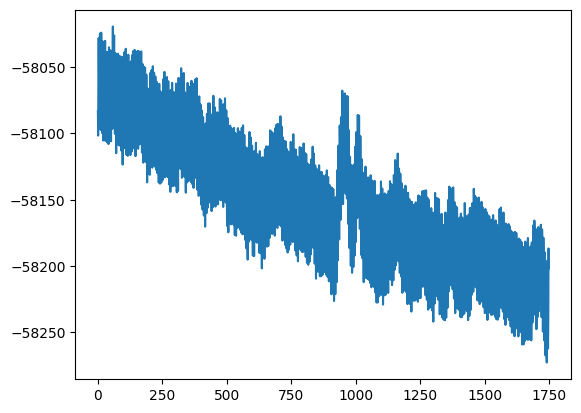

In [7]:
plt.plot(ls[3]["feature"].T[0])

plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

labels = {120: 0, 110: 1, 150: 2}

x = np.array([i["feature"] for i in ls])
y = np.array([labels[i["label"][0]] for i in ls])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(x_train.shape)

(3983, 1750, 17)


In [15]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        feature = self.x[idx].astype(np.float32).T
        label = self.y[idx].astype(np.int64)
        
        return feature, label

In [16]:
train_ds = CustomDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

test_ds = CustomDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [17]:
for i in train_dl:
    print(i[0].shape)
    break

torch.Size([32, 17, 1750])


In [18]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(1750 * 17, 512)  # Input size: 201 * 22, Output size: 512
        self.fc2 = nn.Linear(512, 256)       # Input size: 512, Output size: 256
        self.fc3 = nn.Linear(256, 128)       # Input size: 256, Output size: 128
        self.fc4 = nn.Linear(128, 32)        # Input size: 128, Output size: 64
        self.fc5 = nn.Linear(32, 32)         # Input size: 64, Output size: 32
        self.fc6 = nn.Linear(32, 4)          # Input size: 32, Output size: 4

    def forward(self, x):
        x = x.view(-1, 1750 * 17)  # Flatten the input tensor
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Instantiate the model
model = MyModel()

In [19]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
from sklearn.metrics import accuracy_score

for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    
    y_pred = []
    y_true = []
    for i, data in enumerate(test_dl, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_dl)}, Accuracy: {accuracy}")

Epoch 1, Loss: 7226.103540771484, Accuracy: 0.34236947791164657
Epoch 2, Loss: 494.6435964660645, Accuracy: 0.3333333333333333
Epoch 3, Loss: 185.49458013916015, Accuracy: 0.3293172690763052
Epoch 4, Loss: 102.31760187530517, Accuracy: 0.32028112449799195
Epoch 5, Loss: 52.05958819580078, Accuracy: 0.31827309236947793
Epoch 6, Loss: 25.870528753280638, Accuracy: 0.3373493975903614
Epoch 7, Loss: 28.31821103668213, Accuracy: 0.3463855421686747
Epoch 8, Loss: 13.55335350227356, Accuracy: 0.32028112449799195
Epoch 9, Loss: 13.437920753479004, Accuracy: 0.3293172690763052
Epoch 10, Loss: 12.821642875671387, Accuracy: 0.30220883534136544
Epoch 11, Loss: 9.947025137901306, Accuracy: 0.32831325301204817
Epoch 12, Loss: 5.848572360992431, Accuracy: 0.32429718875502006
Epoch 13, Loss: 5.872883975028992, Accuracy: 0.3313253012048193
Epoch 14, Loss: 10.075879302024841, Accuracy: 0.32429718875502006
Epoch 15, Loss: 12.60065270805359, Accuracy: 0.357429718875502
Epoch 16, Loss: 7.50720504283905, Ac